In [1]:
from relaxations import *
from parameters_estimate import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from chspy import CubicHermiteSpline
from scipy.interpolate import CubicSpline

In [2]:
# read experimental data
df_reversed = pd.read_csv("./data/dollar_insert.csv",header=None)
df = df_reversed.iloc[::-1]
df = df.reset_index(drop=True)

# get indicies for comparison
t0 = 300.00
tf = 1000.00
T = np.arange(0.0,tf,0.01)
t_before_data = (1110-df[0][0])*60
duration_data = (df.iloc[-1][0]-df[0][0])*60
t_end_data = df.iloc[-1][0]
t_before_sim = t0-t_before_data
T_insert = [t for t in T if (t > (t_before_sim)) and (t < (t_before_sim)+(duration_data))]
i_insert = [t[0] for t in enumerate(T) if (t[1] > (t_before_sim)) and (t[1] < (t_before_sim)+(duration_data))]

adj = (df[0][0])*60-T_insert[0]
df[0] = [(t*60)-adj for t in df[0]]

# Set up interpolation
# Assuming df[0] is time and df[1] is the data you want to interpolate
spline = CubicSpline(df[0], df[1])  # Multiplying df[0] by 60 if it's in minutes

# Use the spline to interpolate at the desired times
interpolated_values = spline(T[i_insert[0]:i_insert[-1]+1])


def sumSq_delays(params):
    try:
        # run
        sol_jit = relax_delays(params) # Implement this function to run your model
        
        # calculate error
        simulation_output = [s[46]*P for s in sol_jit][i_insert[0]:(i_insert[-1]+1)]
        error = sum((simulation_output - interpolated_values)**2)  # Sum of squared errors
        return error
    except:
        return float('inf')
    
def sumSq_ht(params):
    try:
        sol_jit = relax_ht(params) # Implement this function to run your model
        
        # calculate error
        simulation_output = [s[46]*P for s in sol_jit][i_insert[0]:(i_insert[-1]+1)]
        error = sum((simulation_output - interpolated_values)**2)  # Sum of squared errors
        return error
    except:
        return float('inf')
    


In [3]:

from scipy.optimize import minimize

def estimate_delays():

    # set bounds
    initial_hx_c_f = 20.0
    hx_c_f_bounds = (10.0, 60.0)
    
    initial_hx_c_c = 20.0
    hx_c_c_bounds = (10.0, 60.0)

    initial_c_hx_f = 20.0
    c_hx_f_bounds = (10.0, 60.0)

    initial_h_loop_f = 1.0
    h_loop_f_bounds = (0.0, 5.0)

    initial_h_btw_f = 0.0
    h_btw_f_bounds = (0.0, 10.0)

    initial_c_hx_c = 20.0
    c_hx_c_bounds = (10.0, 60.0)

    initial_h_loop_c = 1.0
    h_loop_c_bounds = (0.0, 5.0)

    initial_h_btw_c = 0.0
    h_btw_c_bounds = (0.0, 3.0)

    initial_guess = [initial_hx_c_f,initial_hx_c_c,initial_c_hx_f,initial_h_loop_f,
                     initial_h_btw_f,initial_c_hx_c,initial_h_loop_c,initial_h_btw_c]


    bounds = [hx_c_f_bounds,hx_c_c_bounds,c_hx_f_bounds,h_loop_f_bounds,h_btw_f_bounds,
              c_hx_c_bounds,h_loop_c_bounds,h_btw_c_bounds]

    # minimize
    result = minimize(sumSq_delays, initial_guess, bounds=bounds)

    return result

def estimate_ht():

    ft_c = 0.025249076460017884
    ft_c_lims = (ft_c/10,10*ft_c)

    tc_c = 0.0146062610110109899
    tc_c_lims = (tc_c/10,10*tc_c)

    mc_c = 0.00092151047071557199
    mc_c_lims = (mc_c/10,10*mc_c)

    ft_hx = 0.006092568792077965
    ft_hx_lims = (ft_hx/10,10*ft_hx)

    ht_hx = 0.0014320505785117184
    ht_hx_lims = (ht_hx/10,10*ht_hx)

    ct_hx = 0.0101010207925026710110
    ct_hx_lims = (ct_hx/10,10*ct_hx)

    th_hxch = 0.0004489850066827337
    th_hxch_lims = (th_hxch/10,10*th_hxch)

    ht_hxhw = 0.004725554058974901
    ht_hxhw_lims = (ht_hxhw/10,10*ht_hxhw)

    tw_hxhw = 0.3439054124906395
    tw_hxhw_lims = (tw_hxhw/10,10*tw_hxhw)

    ht_hxhwc = 0.0004752963985070788
    ht_hxhwc_lims = (ht_hxhwc/10,10*ht_hxhwc)

    tw_hxhwc = 0.0893816147929607
    tw_hxhwc_lims = (tw_hxhwc/10,10*tw_hxhwc)


    initial_guess = [ft_c,tc_c,mc_c,ft_hx,ht_hx,ct_hx,th_hxch,ht_hxhw,
                     tw_hxhw,ht_hxhwc,tw_hxhwc]
    
    bounds = [ft_c_lims,tc_c_lims,mc_c_lims,ft_hx_lims,ht_hx_lims,ct_hx_lims,
              th_hxch_lims,ht_hxhw_lims,tw_hxhw_lims,ht_hxhwc_lims,tw_hxhwc_lims]

    # minimize
    result = minimize(sumSq_ht, 
                      initial_guess, 
                      bounds=bounds)
                      #method='TNC',
                      #options={'eps': 1e-24})

    return result


In [4]:

result = estimate_ht()

Generating, compiling, and loading C code.
Using default integration parameters.


/mnt/envs/thesis_env/lib/python3.9/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/mnt/envs/thesis_env/lib/python3.9/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle in

Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and l

In [12]:
result.x

array([0.03818585, 0.13432802, 0.0092151 , 0.05857473, 0.00512649,
       0.09000463, 0.00195622, 0.03559712, 0.11966577, 0.00095136,
       0.82463718])

In [5]:
#ft_c = 0.025249076460017884
#tc_c = 0.01460626313109899
#mc_c = 0.0009215347071557199
#ft_hx = 0.006092568792077965
#ht_hx = 0.0012067377947635285
#ct_hx = 0.010332079250267313
#th_hxch = 0.029260886915278107
#ht_hxhw = 0.01034503182042823
#tw_hxhw = 0.007721673144027984
#ht_hxhwc = 0.010628850609552053
#tw_hxhwc = 0.005916855725477816

# Extracting just the variable names into a list
variable_names = ["ft_c", "tc_c", "mc_c", "ft_hx", "ht_hx", "ct_hx", "th_hxch", "ht_hxhw", "tw_hxhw", "ht_hxhwc", "tw_hxhwc"]

for r in enumerate(result.x):
    print(f"{variable_names[r[0]]}: {r[1]}")

ft_c: 0.03818584729406168
tc_c: 0.13432801681223766
mc_c: 0.00921510470715572
ft_hx: 0.05857473090683421
ht_hx: 0.005126490517846378
ct_hx: 0.09000462560773895
th_hxch: 0.001956216516268912
ht_hxhw: 0.03559712411073861
tw_hxhw: 0.11966576582437786
ht_hxhwc: 0.000951359974973591
tw_hxhwc: 0.8246371755658014


In [6]:
# array([19.99999973, 19.99999979, 20.00000013,  1.        ,  0.        ,
#       20.00000011,  0.99999994,  0.        ])
#    initial_hx_c_f = 20.0   
#    initial_hx_c_c = 20.0
#    initial_c_hx_f = 20.0
#    initial_h_loop_f = 1.0
#    initial_h_btw_f = 0.0
#    initial_c_hx_c = 20.0
#    initial_h_loop_c = 1.0
#    initial_h_btw_c = 0.0
#print(sumSq_delays([19.99999973, 19.99999979, 20.00000013,1.,  0.,20.00000011,0.99999994, 0.]))
#print(sumSq_delays([30,30,30,1,1,30,1,1]))
# result.x

array([0.03818585, 0.13432802, 0.0092151 , 0.05857473, 0.00512649,
       0.09000463, 0.00195622, 0.03559712, 0.11966577, 0.00095136,
       0.82463718])

Initial values & solve

In [7]:
#df_reversed = pd.read_csv("./data/dollar_insert.csv",header=None)
#df = df_reversed.iloc[::-1]
#df = df.reset_index(drop=True)

# adjust to reported power
#d = df[1][0]-P
#df[1] = [p-d for p in df[1]]

#plt.plot(df[0],df[1])
#plt.xlabel("Time")
#plt.ylabel("Power (MW)")
#plt.title("ARE: 1$ Reactivity Insertion")

In [8]:
# print(f"a_f: {result.x[0]}")
# print(f"a_b: {result.x[1]}")
# print(f"a_c: {result.x[2]}")
# print(f"insertion: {result.x[3]}")
# print(f"beta_t: {result.x[3]}")
#result

In [13]:
# very close agreement, wide bounds


res_initial = [-8.497785537606717e-05,1.98e-05,6.550691971743104e-05,0.0028672267097399427,0.0028672267097399427]
res_delays = [2.000e+01,  2.000e+01,  2.000e+01,  1.000e+00,  0.000e+00, 2.000e+01,  1.000e+00,  0.000e+00]
res_ht = [0.03818585, 0.13432802, 0.0092151 , 0.05857473, 0.00512649,0.09000463, 0.00195622, 0.03559712, 0.11966577, 0.00095136,0.82463718]

sol_jit = relax_ht(res_ht) 

Generating, compiling, and loading C code.
Using default integration parameters.


/mnt/envs/thesis_env/lib/python3.9/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")


Text(0.5, 1.0, 'ORNL-1845 vs Simulation')

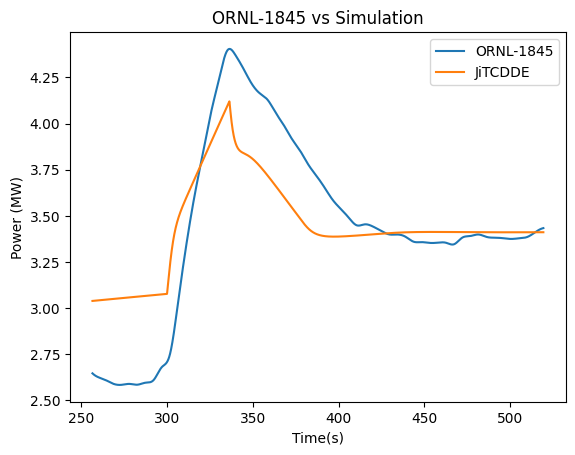

In [14]:
plt.plot(T_insert, interpolated_values,label="ORNL-1845")
plt.plot(T_insert, [s[46]*P for s in sol_jit][i_insert[0]:(i_insert[-1]+1)],label="JiTCDDE")
plt.legend()
plt.ylabel("Power (MW)")
plt.xlabel("Time(s)")
plt.title("ORNL-1845 vs Simulation")

(0.0, 1000.0)

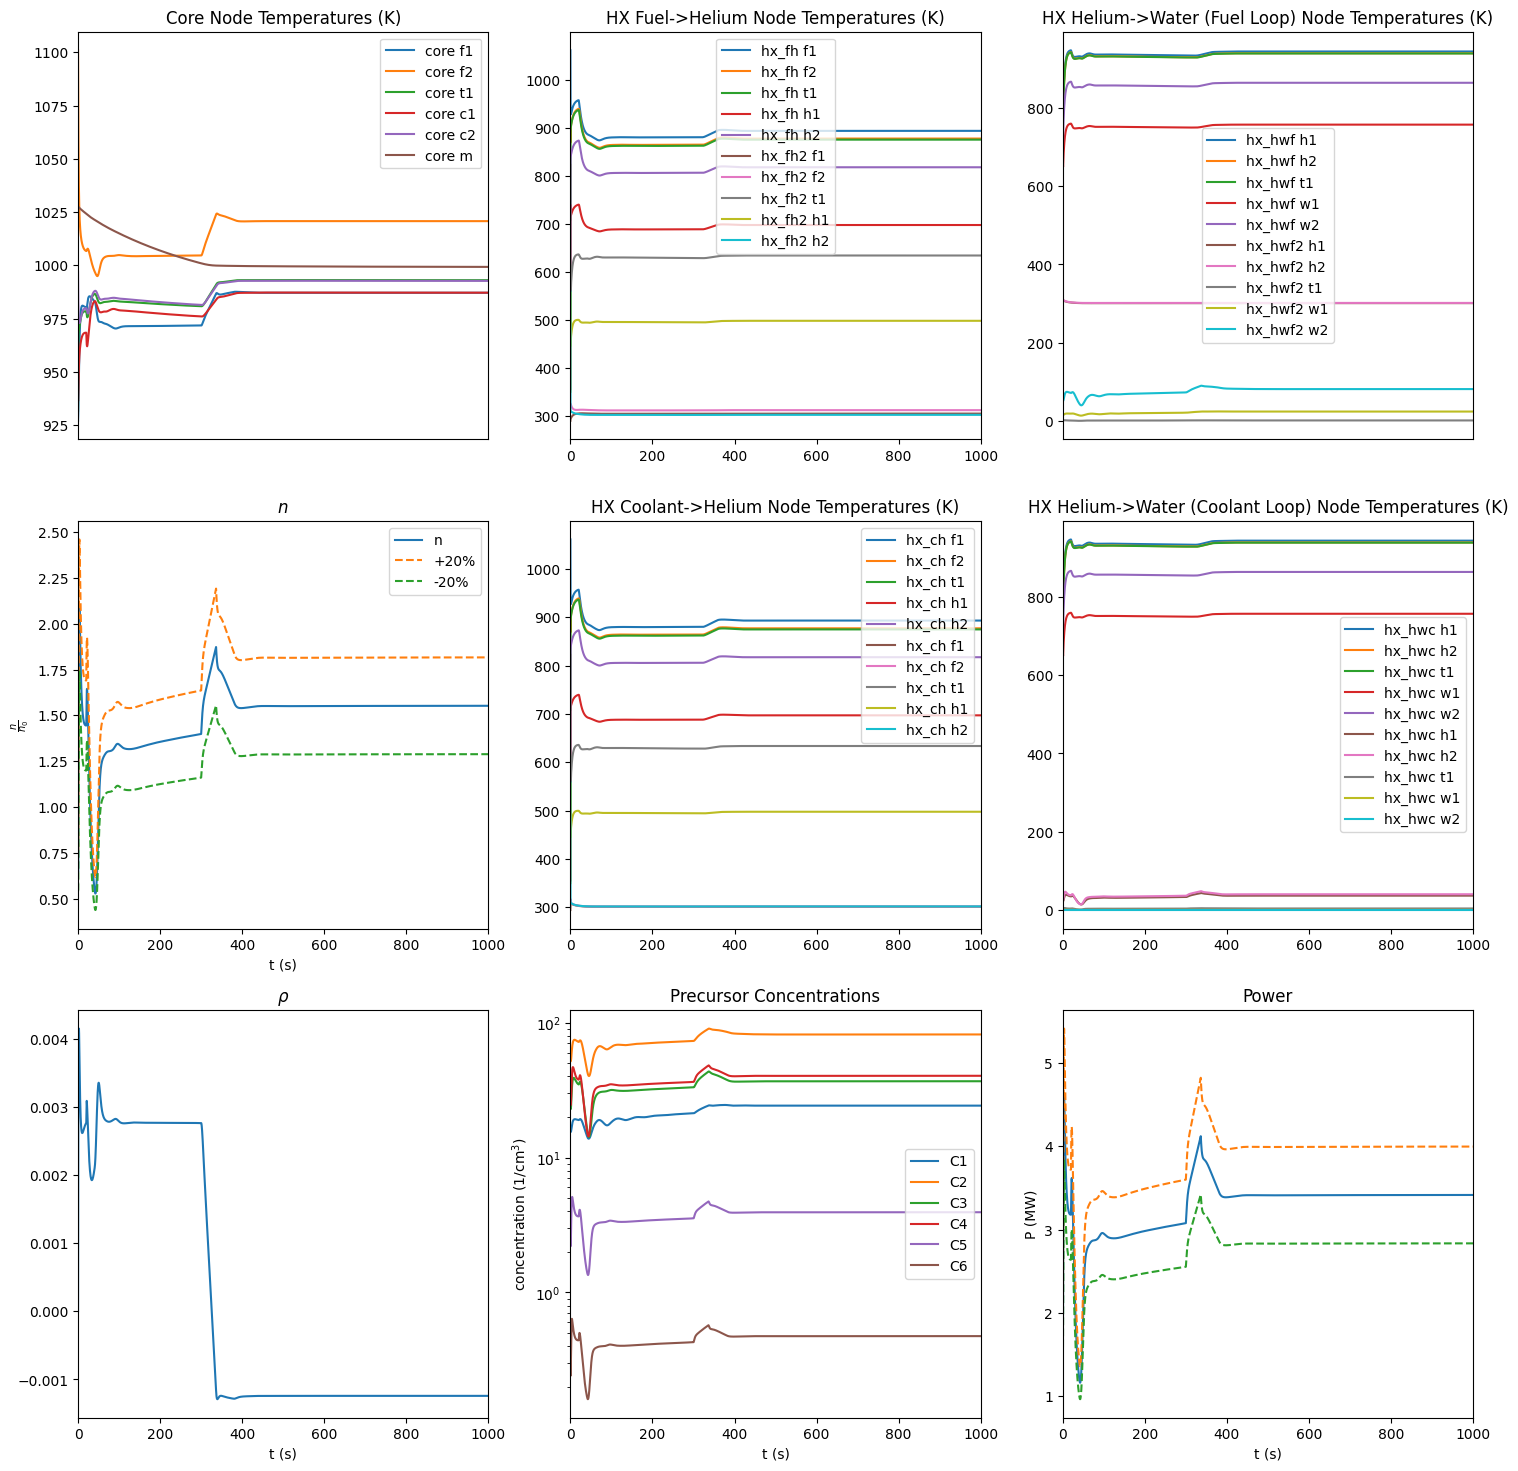

In [11]:
fig,axs = plt.subplots(3,3,figsize=(18,18))

t_0 = 0.0
t_f = 1000
T = np.arange(t_0,t_f,0.01)

p_error = 0.17

axs[0,0].set_xlim([t_0,t_f])
axs[0,0].plot(T,[s[0] for s in sol_jit],label="core f1") 
axs[0,0].plot(T,[s[1] for s in sol_jit],label="core f2") 
axs[0,0].plot(T,[s[2] for s in sol_jit],label="core t1")  
axs[0,0].plot(T,[s[3] for s in sol_jit],label="core c1")
axs[0,0].plot(T,[s[4] for s in sol_jit],label="core c2")
axs[0,0].plot(T,[s[5] for s in sol_jit],label="core m")
axs[0,0].legend()
axs[0,0].set_title("Core Node Temperatures (K)")
axs[0,0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


axs[0,1].set_xlim([t_0,t_f])
# axs[0,1].set_ylim([650,750])
axs[0,1].plot(T,[s[6] for s in sol_jit],label="hx_fh f1") 
axs[0,1].plot(T,[s[7] for s in sol_jit],label="hx_fh f2") 
axs[0,1].plot(T,[s[8] for s in sol_jit],label="hx_fh t1")  
axs[0,1].plot(T,[s[9] for s in sol_jit],label="hx_fh h1")
axs[0,1].plot(T,[s[10] for s in sol_jit],label="hx_fh h2")
axs[0,1].plot(T,[s[34] for s in sol_jit],label="hx_fh2 f1") 
axs[0,1].plot(T,[s[35] for s in sol_jit],label="hx_fh2 f2") 
axs[0,1].plot(T,[s[36] for s in sol_jit],label="hx_fh2 t1")  
axs[0,1].plot(T,[s[37] for s in sol_jit],label="hx_fh2 h1")
axs[0,1].plot(T,[s[38] for s in sol_jit],label="hx_fh2 h2")

axs[0,1].legend()
axs[0,1].set_title("HX Fuel->Helium Node Temperatures (K)")
#axs[0,1].tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off

axs[0,2].set_xlim([t_0,t_f])
axs[0,2].plot(T,[s[16] for s in sol_jit],label="hx_hwf h1") 
axs[0,2].plot(T,[s[17] for s in sol_jit],label="hx_hwf h2") 
axs[0,2].plot(T,[s[18] for s in sol_jit],label="hx_hwf t1")  
axs[0,2].plot(T,[s[19] for s in sol_jit],label="hx_hwf w1")
axs[0,2].plot(T,[s[20] for s in sol_jit],label="hx_hwf w2")
axs[0,2].plot(T,[s[44] for s in sol_jit],label="hx_hwf2 h1") 
axs[0,2].plot(T,[s[45] for s in sol_jit],label="hx_hwf2 h2") 
axs[0,2].plot(T,[s[46] for s in sol_jit],label="hx_hwf2 t1")  
axs[0,2].plot(T,[s[47] for s in sol_jit],label="hx_hwf2 w1")
axs[0,2].plot(T,[s[48] for s in sol_jit],label="hx_hwf2 w2")
axs[0,2].legend()
axs[0,2].set_title("HX Helium->Water (Fuel Loop) Node Temperatures (K)")
axs[0,2].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axs[1,1].set_xlim([t_0,t_f])
axs[1,1].plot(T,[s[11] for s in sol_jit],label="hx_ch f1") 
axs[1,1].plot(T,[s[12] for s in sol_jit],label="hx_ch f2") 
axs[1,1].plot(T,[s[13] for s in sol_jit],label="hx_ch t1")  
axs[1,1].plot(T,[s[14] for s in sol_jit],label="hx_ch h1")
axs[1,1].plot(T,[s[15] for s in sol_jit],label="hx_ch h2")
axs[1,1].plot(T,[s[39] for s in sol_jit],label="hx_ch f1") 
axs[1,1].plot(T,[s[40] for s in sol_jit],label="hx_ch f2") 
axs[1,1].plot(T,[s[41] for s in sol_jit],label="hx_ch t1")  
axs[1,1].plot(T,[s[42] for s in sol_jit],label="hx_ch h1")
axs[1,1].plot(T,[s[43] for s in sol_jit],label="hx_ch h2")
axs[1,1].legend()
axs[1,1].legend()
axs[1,1].set_title("HX Coolant->Helium Node Temperatures (K)")

# fuel temps
axs[1,2].set_xlim([t_0,t_f])
axs[1,2].plot(T,[s[21] for s in sol_jit],label="hx_hwc h1") 
axs[1,2].plot(T,[s[22] for s in sol_jit],label="hx_hwc h2") 
axs[1,2].plot(T,[s[23] for s in sol_jit],label="hx_hwc t1")  
axs[1,2].plot(T,[s[24] for s in sol_jit],label="hx_hwc w1")
axs[1,2].plot(T,[s[25] for s in sol_jit],label="hx_hwc w2")
axs[1,2].plot(T,[s[49] for s in sol_jit],label="hx_hwc h1") 
axs[1,2].plot(T,[s[50] for s in sol_jit],label="hx_hwc h2") 
axs[1,2].plot(T,[s[51] for s in sol_jit],label="hx_hwc t1")  
axs[1,2].plot(T,[s[52] for s in sol_jit],label="hx_hwc w1")
axs[1,2].plot(T,[s[53] for s in sol_jit],label="hx_hwc w2")
axs[1,2].legend()
axs[1,2].set_title("HX Helium->Water (Coolant Loop) Node Temperatures (K)")

axs[1,0].plot(T,[s[46] for s in sol_jit],label="n") 
axs[1,0].plot(T,[(1+p_error)*s[46] for s in sol_jit],linestyle="--",label="+20%") 
axs[1,0].plot(T,[(1-p_error)*s[46] for s in sol_jit],linestyle="--",label="-20%") 
axs[1,0].set_xlabel("t (s)")
axs[1,0].set_title(r"$n$")
axs[1,0].set_ylabel(r"$\frac{n}{n_0}$")
axs[1,0].set_xlim([t_0,t_f])
axs[1,0].legend()

axs[2,0].plot(T,[s[53] for s in sol_jit],label="rho") 
axs[2,0].set_xlabel("t (s)")
axs[2,0].set_title(r"$\rho$")
axs[2,0].set_xlim([t_0,t_f])

axs[2,1].plot(T,[s[47] for s in sol_jit],label="C1") 
axs[2,1].plot(T,[s[48] for s in sol_jit],label="C2") 
axs[2,1].plot(T,[s[49] for s in sol_jit],label="C3")  
axs[2,1].plot(T,[s[50] for s in sol_jit],label="C4")
axs[2,1].plot(T,[s[51] for s in sol_jit],label="C5")
axs[2,1].plot(T,[s[52] for s in sol_jit],label="C6")
axs[2,1].legend()
axs[2,1].set_xlabel("t (s)")
axs[2,1].set_yscale("log")
axs[2,1].set_ylabel(r"concentration (1/cm$^3$)")
axs[2,1].legend(loc="right")
axs[2,1].set_title("Precursor Concentrations")
axs[2,1].set_xlim([t_0,t_f])

axs[2,2].plot(T,[s[46]*P for s in sol_jit],label="Power") 
axs[2,2].plot(T,[(1+p_error)*s[46]*P for s in sol_jit],linestyle="--",label="+20%") 
axs[2,2].plot(T,[(1-p_error)*s[46]*P for s in sol_jit],linestyle="--",label="-20%") 
axs[2,2].set_xlabel("t (s)")
axs[2,2].set_title("Power")
axs[2,2].set_ylabel("P (MW)")
axs[2,2].set_xlim([t_0,t_f])

